# Estimating Contamination from ROH Blocks
In this notebook we walk you through how to use hapCON_auto.py to jointly estimate ROH and contamination rates. The algorithm is described in detail in xxx. For a short introduction and application range of this method, please refer to our [readthedocs site](https://haproh.readthedocs.io/en/latest/hapROH_with_contamination.html).

To run this notebook, you need install the hapROH package (version xxx or higher), [BamTable](https://bioinf.eva.mpg.de/BamTable/) and have samtools in your path. In principle, one only need one of BamTable/samtools, as our method can take either as input. However, we recommend using BamTable in practice as it provides more flexibility when preprocessing your BAM files. 

We use a test BAM file of 0.25x coverage as an example in this tutorial. It was a simulated contaminated BAM files using I4432 (a Latvia hunter-gatherer, 6072-5920 calBCE, whole genome sequenced to average depth 21.23x) as the endogenous source and I5319 (Alaska, USA, 1050-1400 calCE, whole genome sequenced to average depth 21.34x) as the contamination source. The original data was obtained from [Allen Ancient Genome Diversity Project](https://reich.hms.harvard.edu/ancient-genome-diversity-project). You can download our test BAM file from xxx. This endogenous source (I4432) has about ~50cM of ROH and has 10% simulated contamination.


Let's first run ROH contamination estimates using [BamTable](https://bioinf.eva.mpg.de/BamTable/) as input. <span style='color:red'>Please change the path to BamTable binary and BED files according to your own setup. We have assumed that the test BAM file is in directory "./Data"</span>

In [2]:
# please change the path to BamTable and BED file according to your own setup!
!mkdir ./Data/BamTable
!for ch in {1..22}; do /mnt/archgen/users/yilei/bin/BamTable-2.0.3/BamTable -f /mnt/archgen/users/yilei/Data/1000G/1000g1240khdf5/all1240/1240kChr$ch.bed -b -A ./Data/ROH_contam.test.bam > ./Data/BamTable/test.chr$ch.BamTable; done

mkdir: cannot create directory ‘./Data/BamTable’: File exists


<span style='color:red'>Please make sure that the BamTable output files are named as "$iid.chr{1..22}.BamTable"</span> The sample iid is specified via the command line argument -i. Now we are ready to run hapCON_auto.py. It is not very fast (primarily because it has to load the reference panels multiple times) and will take about 12min. The primary output will be named as $iid.$prefix.hapCON_ROH.txt. It contains the final contamination estimates and several other useful information, for example, how many ROH blocks are used in estimation and their total length. At the end of the run, we make a final ROH calling using the estimated contamination rate. The result of this final ROH calling is stored in directory ./hapRoh_iter. You can use this as your sample's final ROH result.

On this particular test BAM file, you should see that the estimated contamination is around 12%. Quite close to the true rate, 10%, for only 0.25x coverage!

In [ ]:
!python3 /mnt/archgen/users/yilei/tools/hapROH/bam/hapCON_auto.py --bamTable ./Data/BamTable -i test -p 4 --prefix iter_ROH

Now let's run ROH contamination estimates using pileup files as input. First, we generate the pileup files using samtools mpileup. As above, 
<span style='color:red'>please change the path to BED files according to your own setup. We have assumed that the test BAM file is in directory "./Data"</span>

In [ ]:
!samtools index ./Data/ROH_contam.test.bam
!mkdir ./Data/mpileup
!for ch in {1..22}; do samtools mpileup --positions /mnt/archgen/users/yilei/Data/1000G/1000g1240khdf5/all1240/1240kChr$ch.bed -r $ch -q 30 -Q 30 -o ./Data/mpileup/test.chr$ch.mpileup ./Data/ROH_contam.test.bam; done

<span style='color:red'>Please make sure that the pileup files are named as "$iid.chr{1..22}.mpileup"</span>

In [ ]:
!python3 /mnt/archgen/users/yilei/tools/hapROH/bam/hapCON_auto.py --mpileup ./Data/mpileup -i test -p 4 --prefix iter_ROH

# Identify False Positive ROH Segments
If you believe that the above procedure has significantly over-estimated contamination rate, or you just want to err on the safe side, you can use the following plotting function to visually examine ROH blocks. This manual checking usually works for samples with coverage 0.5x or higher (ideally ~1x) as one does need a fair amount of reads to visually inspect homozygous regions. Nevertheless, we will use the same sample (0.25x) as above for illustration. 

In the following plot, we check the called ROH block on the sample we just ran hapROH_contam on. It shows a zoom-in onto chromosome 1 40-80cM. The output of hapROH says that there is a 16cM long ROH block on chr1, starting from 47.3cM and ending at 63.4cM. The thick blue bar on the top is the region being called as ROH, and the little blue dots floating on the top are positions that show evidence of heterozygous reads. As this is a sample with 10% simulated contamination, a small amount of heterozygous reads in the ROH block is expected, and we do observe a reduced level of heterozygosity inside the ROH region compared with the rest of the genome.

Successfully loaded Data from: ./Data/hapRoh_iter/test/chr1/


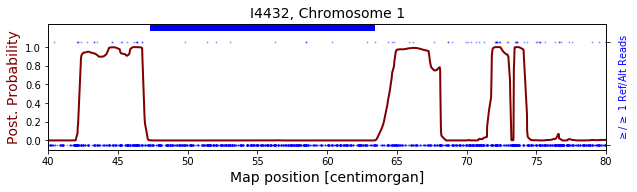

In [2]:
from hapsburg.figures.plot_posterior import plot_posterior_cm
plot_posterior_cm(folder = "./Data/hapRoh_iter/test/chr1/", 
                    savepath="", empirical=True, m=1, cm_lim=[40, 80], groundtruth = False, min_cm=1,
                  readcount=True, figsize=(10,4), title="test, Chromosome 1")